In [25]:
import warnings
warnings.filterwarnings("ignore")
from shapely import wkt
import glob


%load_ext autoreload
%autoreload 2
%env PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj
%matplotlib inline

import skimage

from tqdm import tqdm
import numpy as np
import cv2
from functools import partial

from fastai.imports import *
from fastai.vision import *
from fastai.metrics import dice
from fastai.callbacks import *

from joblib import Parallel, delayed
import torch.nn.functional as F
import torch
import functools, traceback
def gpu_mem_restore(func):
    """Reclaim GPU RAM if CUDA out of memory happened, or execution was interrupted"""
    @functools.wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except:
            type, val, tb = sys.exc_info()
            traceback.clear_frames(tb)
            raise type(val).with_traceback(tb) from None
    return wrapper

os.environ['FASTAI_TB_CLEAR_FRAMES']="1"

from catalyst.contrib.criterion import FocalLossMultiClass, DiceLoss, BCEDiceLoss, LovaszLossBinary,LovaszLossMultiClass

from importlib import reload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: PROJ_LIB=/home/wwymak/anaconda3/envs/solaris/share/proj


In [2]:
def to_onehot(indices, num_classes):
    """Convert a tensor of indices of any shape `(N, ...)` to a
    tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
    input's device`.
    """
    onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                         device=indices.device)
    return onehot.scatter_(1, indices.unsqueeze(1), 1)

    
class FocalLoss(nn.Module):

    def __init__(self, gamma=0, eps=1e-7):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.eps = eps

    def forward(self, input, target, **kwargs):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
        logit = logit.clamp(self.eps, 1. - self.eps)
        loss = F.binary_cross_entropy(logit.float(), y.float())
        loss = loss * (1 - logit) ** self.gamma # focal loss
        return loss.sum(dim=1).mean()

In [19]:

class CombinedLoss(nn.Module):

    def __init__(self):
        super(CombinedLoss, self).__init__()

    def forward(self, input, target):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=2.)
        bce_dice = BCEDiceLoss()
        lovaz_loss = LovaszLossBinary()
        dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = 0.8 * focal_loss(logit, target) + 0.2 * dice_loss(logit, y)
        return total_loss

In [4]:
data_dir = Path("/media/wwymak/Storage/xView2")
models_path = data_dir / "models"
classifcation_crop_dir = data_dir/"classification_crops"
classification_labels = pd.read_csv(data_dir/"train.csv")

damage_crops_test_folder = data_dir / "classification_crops_test"

In [7]:
def get_train_valid_ids(classification_labels_df, valid_pct=0.1, random_seed=42):
    np.random.seed(random_seed)
    unique_img_ids = classification_labels_df.img_id.unique()
    np.random.shuffle(unique_img_ids)
    train_img_ids = unique_img_ids[:int(len(unique_img_ids) * (1- valid_pct))]
    valid_img_ids = unique_img_ids[int(len(unique_img_ids) * (1- valid_pct)):]
    
    train_ids = classification_labels_df[classification_labels_df.img_id.isin(train_img_ids)].crop_filename.values
    valid_ids = classification_labels_df[classification_labels_df.img_id.isin(valid_img_ids)].crop_filename.values
    
    return train_ids, valid_ids
    

In [8]:
train_ids, valid_ids = get_train_valid_ids(classification_labels)
classification_labels_resampled= pd.concat([
    classification_labels[(classification_labels.label!= 0) & (~classification_labels.crop_filename.isin(valid_ids))],
    classification_labels[(classification_labels.label==0) & (~classification_labels.crop_filename.isin(valid_ids))].sample(frac=0.2),
    classification_labels[classification_labels.crop_filename.isin(valid_ids)],
])

In [9]:
def is_valid_func(img_fname):
    id = Path(img_fname).name
    return id in valid_ids

def f1(y_pred:Tensor, y_true:Tensor):
    eps=1e-10
    def to_onehot(indices, num_classes):
        """Convert a tensor of indices of any shape `(N, ...)` to a
        tensor of one-hot indicators of shape `(N, num_classes, ...) and of type uint8. Output's device is equal to the
        input's device`.
        """
        onehot = torch.zeros(indices.shape[0], num_classes, *indices.shape[1:],
#                              dtype=torch.uint8,
                             device=indices.device)
        return onehot.scatter_(1, indices.unsqueeze(1), 1)
    def recall(y_pred,y_true):
        """Recall metric.
        Only computes a batch-wise average of recall.
        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        possible_positives = torch.sum(y_true)
        recall = true_positives / (possible_positives + eps)
        return recall

    def precision(y_pred,y_true):
        """Precision metric.
        Only computes a batch-wise average of precision.
        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
        predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives +eps)
        return precision

    y_true = to_onehot(y_true.view(-1), num_classes=4)
    precision = precision(y_pred,y_true)
    recall = recall(y_pred,y_true)
    return 2*((precision*recall)/(precision+recall+eps))#


In [10]:
size=64
bs=32
partial_data_frac=0.2
src = (ImageList
       .from_df(classification_labels_resampled, path=classifcation_crop_dir, cols=['crop_filename'])
#        .use_partial_data(partial_data_frac)
       .split_by_valid_func(is_valid_func)
       .label_from_df(cols='label'))
data2 = (src
        .transform(get_transforms(do_flip=True, 
             flip_vert=True, 
             max_rotate=180, 
             max_zoom=1.2, 
             max_lighting=0.5,
             max_warp=0.2, 
             p_affine=0.75, 
             p_lighting=0.75), size=size, tfm_y=False)
        .add_test_folder(damage_crops_test_folder)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = cnn_learner(data2,models.resnet50, metrics=[accuracy, f1])
learn.model_dir = models_path
learn.loss_func =CombinedLoss();
learn.to_fp16();

here


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


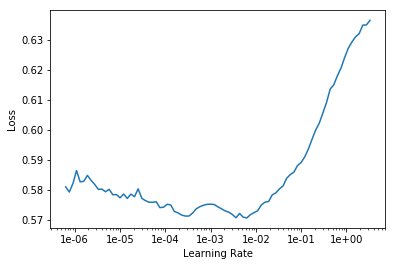

In [20]:
learn.loss_func =CombinedLoss();
learn.to_fp16();
print('here')
learn.lr_find();
learn.recorder.plot();

In [21]:
learn.fit_one_cycle(1, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.558770,0.536462,0.705698,0.647614,02:03


In [22]:
learn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.554832,0.538180,0.699360,0.634080,02:01
1,0.558378,0.531443,0.716589,0.644322,02:04
2,0.546158,0.533766,0.711359,0.647134,02:08


In [23]:

class CombinedLoss(nn.Module):

    def __init__(self):
        super(CombinedLoss, self).__init__()

    def forward(self, input, target):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=2.)
        bce_dice = BCEDiceLoss()
        lovaz_loss = LovaszLossBinary()
        dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = 0.1 * focal_loss(logit, target) + 0.9 * dice_loss(logit, y)
        return total_loss
    
learn.loss_func =CombinedLoss();
learn.to_fp16();
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.623666,0.601639,0.715112,0.700390,02:05
1,0.617839,0.603647,0.710928,0.689876,02:07


In [28]:
class CombinedLoss(nn.Module):

    def __init__(self):
        super(CombinedLoss, self).__init__()

    def forward(self, input, target):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=2.)
        bce_dice = BCEDiceLoss(activation='Softmax')
        lovaz_loss = LovaszLossMultiClass()
        dice_loss = DiceLoss(activation='Softmax')
        
#         total_loss = 0.1 * focal_loss(logit, target) + 0.9 * dice_loss(logit, y)
        return bce_dice(logit, y)
learn.loss_func =CombinedLoss();
learn.to_fp16();
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.657684,0.646456,0.689577,0.683151,01:58
1,0.653925,0.641372,0.709267,0.694585,01:58


In [29]:
class CombinedLoss(nn.Module):

    def __init__(self):
        super(CombinedLoss, self).__init__()

    def forward(self, input, target):
        y = to_onehot(target, input.size(-1))
        logit = F.softmax(input)
                     
        focal_loss = FocalLossMultiClass(gamma=2.)
        bce_dice = BCEDiceLoss(activation='Softmax')
        lovaz_loss = LovaszLossMultiClass()
        dice_loss = DiceLoss(activation='Softmax')
        
        total_loss = 0.5 * focal_loss(logit, target) + 0.5 * bce_dice(logit, y)
        return bce_dice(logit, y)
learn.loss_func =CombinedLoss();
learn.to_fp16();
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.656582,0.641241,0.710805,0.689855,02:07
1,0.648313,0.635035,0.733141,0.706821,02:06
